In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from itertools import product

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('dataset.csv', index_col=False)
not_features = ["Path", "Emotional_intensity", "Statement", "Gender"]
features_data = dataset.drop(columns=not_features)

features_data.dropna(inplace=True)
actor_list = [1, 12, 7, 24]
test_set = features_data.loc[features_data['Actor'].isin(actor_list)]
training_set = features_data.drop(test_set.index)

In [3]:
""" training_actors = training_set['Actor']
training_actors = training_actors.unique()

print(training_actors)

training_actors_m = []
training_actors_f = []
for actor in training_actors:
    if (actor%2 == 0):
        training_actors_f.append(actor)
    else:
        training_actors_m.append(actor) """

" training_actors = training_set['Actor']\ntraining_actors = training_actors.unique()\n\nprint(training_actors)\n\ntraining_actors_m = []\ntraining_actors_f = []\nfor actor in training_actors:\n    if (actor%2 == 0):\n        training_actors_f.append(actor)\n    else:\n        training_actors_m.append(actor) "

In [4]:
# Separazione attori per genere (parità di genere)
training_actors = training_set['Actor'].unique()
training_actors_m = [actor for actor in training_actors if actor % 2 != 0]
training_actors_f = [actor for actor in training_actors if actor % 2 == 0]

In [5]:
# Definisci feature ed etichetta per training e test set
X2d_train = training_set.drop(columns=['Emotions'])  # Escludi la colonna dell'etichetta
y_train = training_set['Emotions']                 # Colonna etichetta

X2d_test = test_set.drop(columns=['Emotions'])       # Escludi la colonna dell'etichetta
y_test = test_set['Emotions']                      # Colonna etichetta

# Verifica i dati (opzionale)
print("X_train:\n", X2d_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X2d_test.head())
print("y_test:\n", y_test.head())

X_train:
     Actor  Chroma_1  Chroma_2  Chroma_3  Chroma_4  Chroma_5  Chroma_6  \
60      2  0.449431  0.431913  0.422490  0.454994  0.449320  0.466227   
61      2  0.486225  0.485757  0.481704  0.490454  0.504468  0.513672   
62      2  0.525115  0.512116  0.539546  0.533606  0.552692  0.572779   
63      2  0.479317  0.478523  0.474578  0.484419  0.529331  0.550069   
64      2  0.566381  0.508163  0.506020  0.521153  0.540124  0.567265   

    Chroma_7  Chroma_8  Chroma_9  ...  SpectralContrast_4  SpectralContrast_5  \
60  0.483222  0.501104  0.498397  ...           14.571050           16.666075   
61  0.523946  0.543750  0.553068  ...           14.659985           16.021583   
62  0.585125  0.575789  0.549689  ...           14.071312           15.944679   
63  0.539958  0.514924  0.508265  ...           13.641717           15.368279   
64  0.549716  0.549326  0.572161  ...           14.803141           16.888986   

    SpectralContrast_6  SpectralContrast_7  Tonnetz_1  Tonnetz_2

In [6]:
# definire i modelli
model1 = RandomForestClassifier(n_jobs=-1, random_state=42)
model2 = XGBClassifier(objective='binary:logistic', random_state=42)
model3 = GradientBoostingClassifier(random_state=42, warm_start=True)
model4 = LogisticRegression(random_state=42)
model5 = MLPClassifier(random_state=42)
model6 = SVC(random_state=42)

 # definire gli iperparametri
param_gridRfc = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None], 
    "min_samples_split": [2, 5], 
    "min_samples_leaf": [1, 2],   
}

param_gridXGB = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3, 6],          
    "colsample_bytree": [0.5, 0.7, 1], 
}

param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [2,3],         
    "subsample": [0.6, 0.7, 0.8],     
    "learning_rate": [0.05, 0.1],
}

param_grid_logreg = {
    "C": [0.01, 0.1, 1, 10],               
    "solver": ["lbfgs", "liblinear", "saga"],
}

param_grid_mlp = {
    "hidden_layer_sizes": [(50,50), (50,50,50), (100,)],
    "alpha": [0.0001, 0.001, 0.01],                
    "learning_rate_init": [0.001, 0.01],     
}

param_grid_svc = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "rbf"],   
    "gamma": ["scale", "auto"],    
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def save_model_params(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_model_params(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

# Funzione per eseguire la GridSearch
def GridSearch(model, param_grid, save_file): 
    best_score = 0.0
    best_params = {}

    # Prova a caricare i risultati intermedi se esistono
    saved_data = load_model_params(save_file)
    if saved_data:
        print("Caricamento dei risultati intermedi...")
        best_score, best_params = saved_data
            
    param_names = param_grid.keys()
    param_values = param_grid.values()
    param_combinations = list(product(*param_values))

    # Funzione per essere eseguita in parallelo
    def evaluate_combination(params):
        param_combination = dict(zip(param_names, params))
        model_accuracy = []
        model_f1 = []

        for i in range(10):
            m = training_actors_m[i]
            f = training_actors_f[i]
            cross_test_set = training_set.loc[training_set['Actor'].isin([m, f])]
            cross_training_set = training_set.drop(cross_test_set.index)

            y_train = cross_training_set["Emotions"]
            X2d_train = cross_training_set.drop(columns=['Emotions', 'Actor'])  # Escludi colonne non feature
            y_test = cross_test_set["Emotions"]
            X2d_test = cross_test_set.drop(columns=['Emotions', 'Actor'])  # Escludi colonne non feature
            # Crea una nuova istanza del modello
            model_instance = model.__class__(**param_combination)

            # Fai il fitting del modello
            model_instance.fit(X2d_train, y_train)

            # Registra i risultati
            model_accuracy.append(model_instance.score(X2d_test, y_test))
            y_pred = model_instance.predict(X2d_test)
            model_f1.append(f1_score(y_test, y_pred, average="macro"))

        avg_accuracy = sum(model_accuracy) / len(model_accuracy)
        avg_f1 = sum(model_f1) / len(model_f1)

        return param_combination, avg_accuracy, avg_f1

    # Parallelizza la valutazione delle combinazioni
    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(params) for params in param_combinations)

    for param_combination, avg_accuracy, avg_f1 in results:
        if avg_accuracy > best_score:
            best_score = avg_accuracy
            best_params = param_combination

    # Salva il miglior risultato raggiunto finora
        save_model_params(save_file, (best_score, best_params))
        print(f"Parameters: {param_combination}")
        print(f"Average Accuracy: {avg_accuracy}")
        print(f"Average F1 Score: {avg_f1}")
        print("--------------------")

    print("Best parameters:")
    print(best_params)
    print(f"Best Accuracy: {best_score}")
    print("--------------------")

In [8]:
#richiamo la funzione per stampare le migliori combinazioni, RandomForest
GridSearch(model1, param_gridRfc, "random_forest_params.pkl")

Caricamento dei risultati intermedi...
Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
Average Accuracy: 0.4008333333333334
Average F1 Score: 0.3606020287029338
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}
Average Accuracy: 0.3975
Average F1 Score: 0.3654774485272484
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}
Average Accuracy: 0.3908333333333333
Average F1 Score: 0.3565731713470021
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Average Accuracy: 0.39333333333333337
Average F1 Score: 0.35246327790846893
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}
Average Accuracy: 0.39416666666666667
Average F1 Score: 0.36242588396129255
--------------------
Para

In [9]:
#XGBoost
GridSearch(model2, param_gridXGB, "xgboost_params.pkl")

Caricamento dei risultati intermedi...


Parameters: {'n_estimators': 200, 'max_depth': 3, 'colsample_bytree': 0.5}
Average Accuracy: 0.4058333333333334
Average F1 Score: 0.38514576625405905
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 3, 'colsample_bytree': 0.7}
Average Accuracy: 0.41083333333333333
Average F1 Score: 0.3864835880678685
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 3, 'colsample_bytree': 1}
Average Accuracy: 0.4175
Average F1 Score: 0.3981892610338039
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 6, 'colsample_bytree': 0.5}
Average Accuracy: 0.4225
Average F1 Score: 0.4040523846848597
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 6, 'colsample_bytree': 0.7}
Average Accuracy: 0.42333333333333334
Average F1 Score: 0.40899666707701454
--------------------
Parameters: {'n_estimators': 200, 'max_depth': 6, 'colsample_bytree': 1}
Average Accuracy: 0.4141666666666667
Average F1 Score: 0.40160239441568335
--------------------
Par

In [10]:
# GradientBoosting
GridSearch(model3, param_grid_gb, "gradient_boosting_params.pkl")


Caricamento dei risultati intermedi...
Parameters: {'n_estimators': 100, 'max_depth': 2, 'subsample': 0.6, 'learning_rate': 0.05}
Average Accuracy: 0.4125
Average F1 Score: 0.393747328585471
--------------------
Parameters: {'n_estimators': 100, 'max_depth': 2, 'subsample': 0.6, 'learning_rate': 0.1}
Average Accuracy: 0.4083333333333333
Average F1 Score: 0.3826798597398763
--------------------
Parameters: {'n_estimators': 100, 'max_depth': 2, 'subsample': 0.7, 'learning_rate': 0.05}
Average Accuracy: 0.4066666666666666
Average F1 Score: 0.3834740558215349
--------------------
Parameters: {'n_estimators': 100, 'max_depth': 2, 'subsample': 0.7, 'learning_rate': 0.1}
Average Accuracy: 0.4041666666666667
Average F1 Score: 0.3783558462325183
--------------------
Parameters: {'n_estimators': 100, 'max_depth': 2, 'subsample': 0.8, 'learning_rate': 0.05}
Average Accuracy: 0.4066666666666666
Average F1 Score: 0.3844390810750763
--------------------
Parameters: {'n_estimators': 100, 'max_depth':

In [11]:
GridSearch(model4, param_grid_logreg, "logreg_params.pkl") # Logistic Regression

Caricamento dei risultati intermedi...
Parameters: {'C': 0.01, 'solver': 'lbfgs'}
Average Accuracy: 0.38666666666666666
Average F1 Score: 0.35259976381853814
--------------------
Parameters: {'C': 0.01, 'solver': 'liblinear'}
Average Accuracy: 0.3908333333333333
Average F1 Score: 0.3511943026738598
--------------------
Parameters: {'C': 0.01, 'solver': 'saga'}
Average Accuracy: 0.3516666666666667
Average F1 Score: 0.3112129006527581
--------------------
Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Average Accuracy: 0.3783333333333333
Average F1 Score: 0.34232942116187765
--------------------
Parameters: {'C': 0.1, 'solver': 'liblinear'}
Average Accuracy: 0.3825
Average F1 Score: 0.34333233269002705
--------------------
Parameters: {'C': 0.1, 'solver': 'saga'}
Average Accuracy: 0.35
Average F1 Score: 0.3100519504951505
--------------------
Parameters: {'C': 1, 'solver': 'lbfgs'}
Average Accuracy: 0.37916666666666665
Average F1 Score: 0.33892926865976525
--------------------
Parameters: {'C

In [12]:
GridSearch(model5, param_grid_mlp, "mlp_params.pkl")        # MLPClassifier

Caricamento dei risultati intermedi...
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'learning_rate_init': 0.001}
Average Accuracy: 0.36
Average F1 Score: 0.30216321027210846
--------------------
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'learning_rate_init': 0.01}
Average Accuracy: 0.355
Average F1 Score: 0.3128345333316983
--------------------
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'learning_rate_init': 0.001}
Average Accuracy: 0.38
Average F1 Score: 0.32986017558789
--------------------
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'learning_rate_init': 0.01}
Average Accuracy: 0.37333333333333335
Average F1 Score: 0.3349009621604183
--------------------
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.01, 'learning_rate_init': 0.001}
Average Accuracy: 0.3775
Average F1 Score: 0.3418673914706404
--------------------
Parameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.01, 'learning_rate_init': 0.01}
Av

In [13]:
GridSearch(model6, param_grid_svc, "svc_params.pkl")    # SVC

Caricamento dei risultati intermedi...
Parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
Average Accuracy: 0.4025
Average F1 Score: 0.3636120841722644
--------------------
Parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 'auto'}
Average Accuracy: 0.4025
Average F1 Score: 0.3636120841722644
--------------------
Parameters: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
Average Accuracy: 0.2866666666666667
Average F1 Score: 0.19782813828744272
--------------------
Parameters: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'}
Average Accuracy: 0.22333333333333333
Average F1 Score: 0.1805458337075741
--------------------
Parameters: {'C': 1, 'kernel': 'linear', 'gamma': 'scale'}
Average Accuracy: 0.3883333333333333
Average F1 Score: 0.3530346266185246
--------------------
Parameters: {'C': 1, 'kernel': 'linear', 'gamma': 'auto'}
Average Accuracy: 0.3883333333333333
Average F1 Score: 0.3530346266185246
--------------------
Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
Aver

RandomForest - Matrice di Confusione


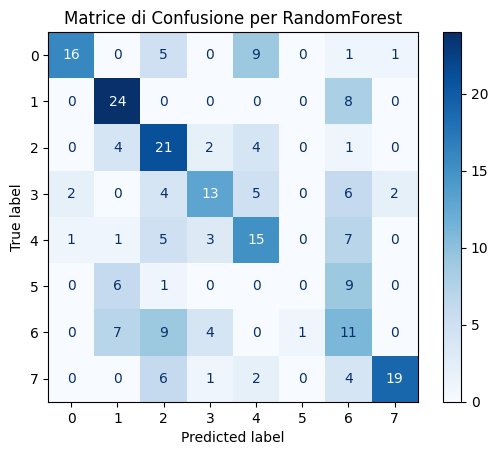

XGBoost - Matrice di Confusione


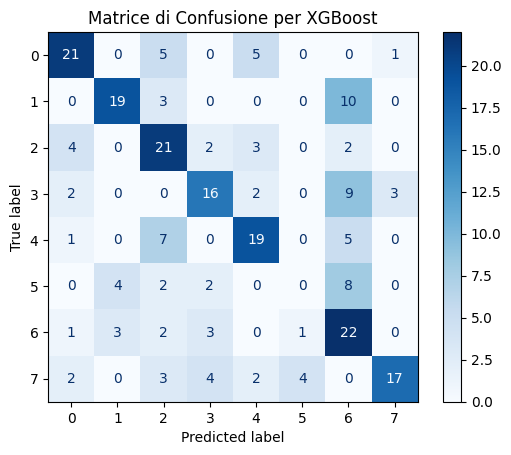

GradientBoosting - Matrice di Confusione


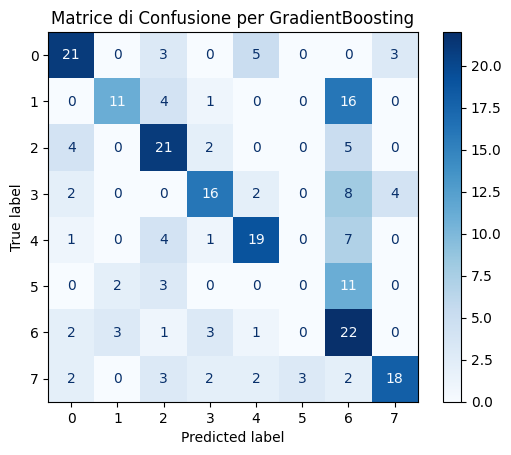

LogisticRegression - Matrice di Confusione


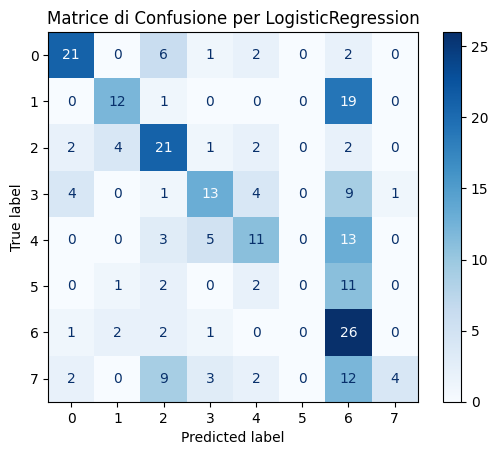

MLPClassifier - Matrice di Confusione


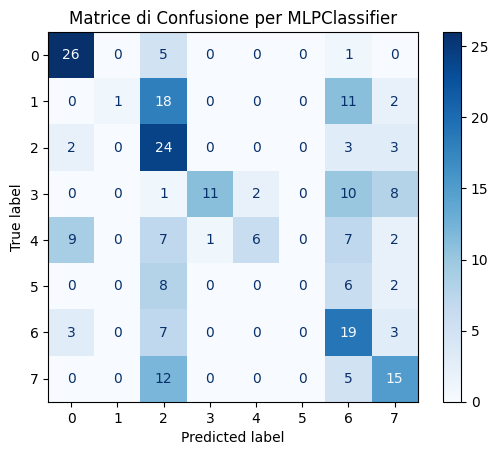

SVC - Matrice di Confusione


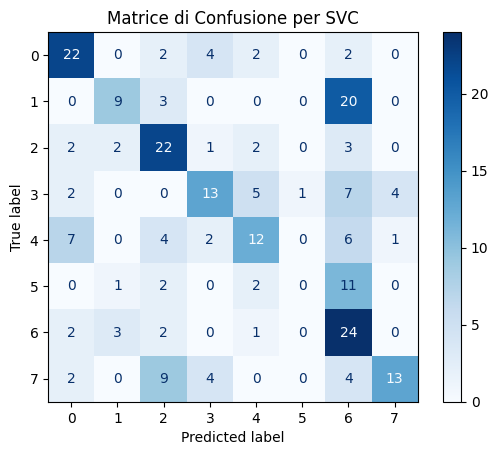

RandomForest - Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy: 0.49583333333333335
Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.50      0.63        32
        calm       0.57      0.75      0.65        32
     disgust       0.41      0.66      0.51        32
     fearful       0.57      0.41      0.47        32
       happy       0.43      0.47      0.45        32
     neutral       0.00      0.00      0.00        16
         sad       0.23      0.34      0.28        32
   surprised       0.86      0.59      0.70        32

    accuracy                           0.50       240
   macro avg       0.49      0.46      0.46       240
weighted avg       0.52      0.50      0.49       240


XGBoost - Best Params: {'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.5625
Classification Report:
              precision    recall  f1-score   support

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Dizionario per raccogliere i risultati
results = {}

# Esegui GridSearchCV e valutazione per ogni modello
for model, params, name in [
    (model1, param_gridRfc, "RandomForest"),
    (model2, param_gridXGB, "XGBoost"),
    (model3, param_grid_gb, "GradientBoosting"),
    (model4, param_grid_logreg, "LogisticRegression"),
    (model5, param_grid_mlp, "MLPClassifier"),
    (model6, param_grid_svc, "SVC")
]:
    grid = GridSearchCV(model, params, cv=skf, scoring='accuracy', n_jobs=-1)
    
    # Esegui la ricerca degli iperparametri sul set di addestramento
    grid.fit(X2d_train, y_train)
    best_model = grid.best_estimator_

    # Valutazione sul set di test
    y_pred = best_model.predict(X2d_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Memorizza i risultati
    results[name] = {
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Classification Report": classification_report(y_test, y_pred, zero_division=1),  # Set zero_division to avoid warnings
        "Confusion Matrix": conf_matrix
    }
    
    # Mostra la matrice di confusione
    print(f"{name} - Matrice di Confusione")
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap="Blues")
    plt.title(f"Matrice di Confusione per {name}")
    plt.show()
    
# Mostra i risultati
for name, res in results.items():
    print(f"{name} - Best Params: {res['Best Params']}")
    print(f"Accuracy: {res['Accuracy']}")
    print(f"Classification Report:\n{res['Classification Report']}\n")




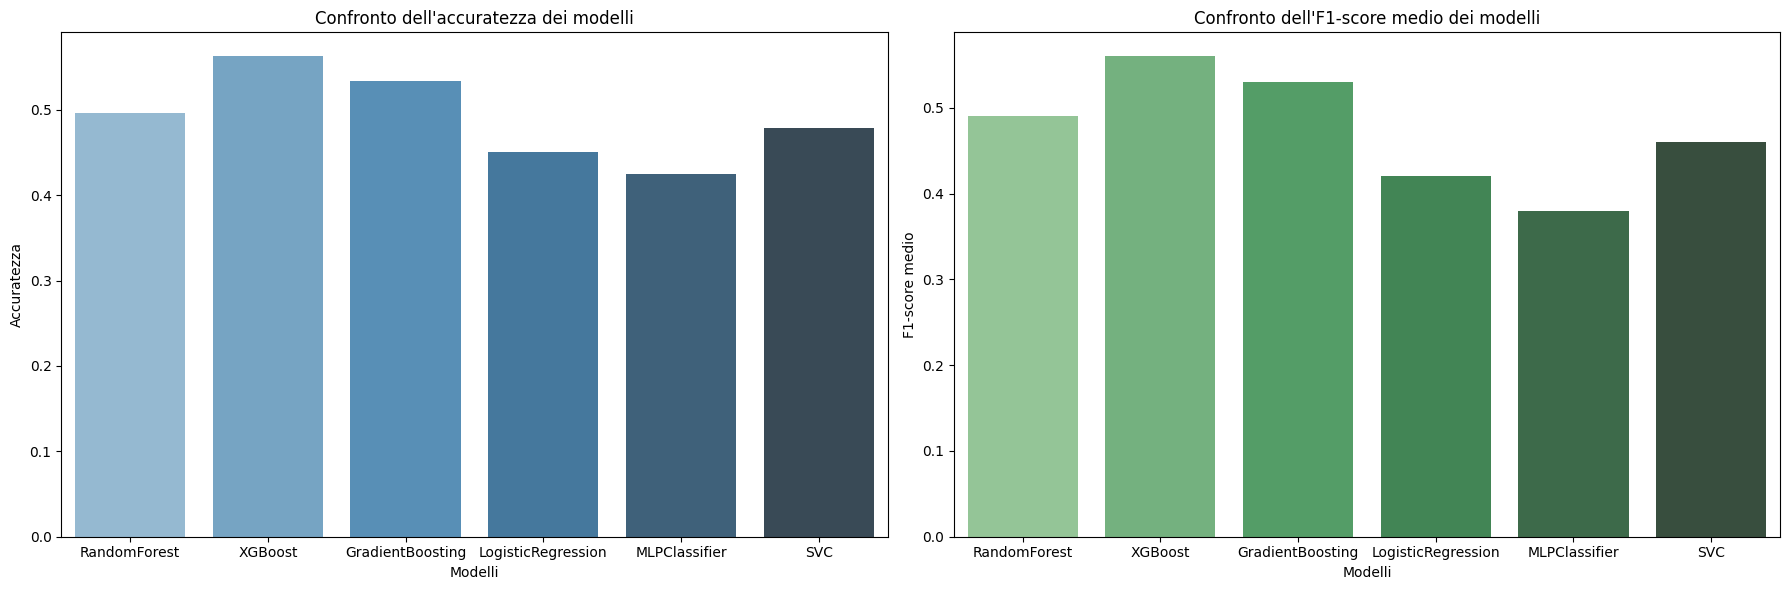

In [23]:
# Dizionari per memorizzare l'accuratezza e l'f1-score medio per ogni modello
model_names = []
accuracies = []
f1_scores = []

# Estrai i dati dal dizionario results
for name, res in results.items():
    model_names.append(name)
    accuracies.append(res["Accuracy"])
    
    # Calcola l'f1-score medio
    report = res["Classification Report"]
    f1_score_avg = report.split()[-2]  # Ottieni la media f1-score
    f1_scores.append(float(f1_score_avg))

# Grafico a barre per Accuratezza e F1-score medio
plt.figure(figsize=(18, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=accuracies, hue=model_names, palette="Blues_d", dodge=False, legend=False)
plt.title("Confronto dell'accuratezza dei modelli")
plt.xlabel("Modelli")
plt.ylabel("Accuratezza")

# Plot f1-scores
plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=f1_scores, hue=model_names, palette="Greens_d", dodge=False, legend=False)
plt.title("Confronto dell'F1-score medio dei modelli")
plt.xlabel("Modelli")
plt.ylabel("F1-score medio")

plt.tight_layout()
plt.show()
